# Over/Under Bootstrap Simulations

In this notebook I will use box score data from the 2024-2025 NHL season to create 95% confidence intervals for the amount of money someone would win or lose if they bet on the "Over" on every time "Under" on every time or flipped a coin for "Over/Under" every time they made N number of bets in a specified month.

I will apply bootstrapping to the sampling of the games to address variability in the samples.

Description of the data I am using, initial exploration and cleaning can be found in the [Over Under EDA](./over-under-EDA.ipynb) notebook.

In [ ]:
#set these variables to modify the simulations
#the simulation will place 2 .png files in the results/ folder
#One file is a table of ROI percentages for the three months and three bet types
#The other file is a 95% CI with how much money you would win or lose based on these settings
WAGER_AMOUNT = 100
#166 max = every game in October 
BETS_PER_MONTH = 150
#if full_month. # of bets per month ignored
FULL_MONTH = True

In [322]:
from data_utils import load_and_clean_over_under_data
over_under_df = load_and_clean_over_under_data()

In [323]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from typing import Literal
import os
from matplotlib.ticker import FuncFormatter
from pandas.plotting import table

def dollar_formatter(x, pos):
    return f'${x:,.0f}'


In [ ]:
#These functions are used to calculate the money won or lost for a game (row)
def calculate_win(wager: float, odds: int)->float:
    return wager * (100 / abs(odds))

#pass the wager ammount, bet_type and the row
#returns the amount won or lost
def calculate_bet(wager: float, bet_type: Literal['OVER', 'UNDER', 'RANDOM'], row: pd.Series)->float:
    if bet_type == 'RANDOM':
        bet_type = np.random.choice(['OVER', 'UNDER'])

    if bet_type == 'OVER':
        if row['OVER_HIT'] == True:
            #calculate win
            odds = row['OVER_ODDS']
            return calculate_win(wager, odds)
        elif row['OVER_HIT'] == False:
            #lost your wager
            return wager * -1
        else:
            #push
            return wager
    else:
        if row['UNDER_HIT'] == True:
            #calculate win
            odds = row['UNDER_ODDS']
            return calculate_win(wager, odds)
        elif row['UNDER_HIT'] == False:
            #lost your wager
            return wager * -1
        else:
            #push
            return wager


In [ ]:
#quick test it works
random_row = over_under_df.sample(n=1).iloc[0]
test_bet = calculate_bet(10, 'OVER', random_row)
print(test_bet)

-10


In [ ]:
#calculate the total winnings or losses for a month based on 
# the wager amount, bet type and number of bets that month
def sample_month(month: int, sample_size: int, wager_amount: float, bet_type: Literal['OVER', 'UNDER', 'RANDOM']):
    #filter month data
    month_data = over_under_df[over_under_df['MONTH'] == month].copy()
    #bootstrap the samples
    bootstrap_month_data = month_data.sample(n=len(month_data), replace=True)
    #select a number of games from that month to bet on
    if FULL_MONTH:
        sample_games = bootstrap_month_data
    else:
        sample_games = bootstrap_month_data.sample(n=sample_size,replace=False)
    #calculate the total winnings/losses
    total_result = sample_games.apply(lambda row: calculate_bet(wager_amount, bet_type, row), axis=1).sum()
    return total_result

In [ ]:
#function that runs the simulation
#returns the mean, SE, lower and upper quantile
def run_sampling_simulation(month: int, wager_amount: float, games_per_month: int, wager_type: Literal['OVER', 'UNDER', 'RANDOM']):
    wager_results = []
    for _ in range(10_000):
        wager_result = sample_month(month, games_per_month, wager_amount, wager_type)
        wager_results.append(wager_result)
    sample_mean =  np.mean(wager_results)
    sample_se_of_mean = np.std(wager_results)
    lower = np.quantile(wager_results, 0.025)
    upper = np.quantile(wager_results, 0.975)

    return {
        "wager_results": wager_results,
        "mean": sample_mean,
        "se_of_mean": sample_se_of_mean, 
        "lower": lower, 
        "upper": upper
    }

In [ ]:
#function used to plot the results
def plot_results(results, month_label):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True, sharex=True)
    if FULL_MONTH:
        fig.suptitle(f"{dollar_formatter(WAGER_AMOUNT, None)} Bets For Every Game", fontsize=16)
    else:
        fig.suptitle(f"For {BETS_PER_MONTH} {dollar_formatter(WAGER_AMOUNT, None)} Bets Per Month", fontsize=16)
    
    for ax, (label, result) in zip(axes, results):
        wager_results = result["wager_results"]
        sample_mean = result["mean"]
        lower = result["lower"]
        upper = result["upper"]
        ax.hist(wager_results, edgecolor='black')
        ax.set_xlabel('Sample Total Winnings')
        ax.set_title(f'{month_label}, {label} Bets')
        ax.axvline(sample_mean, color='orange', linestyle='dashed', linewidth=2, label=f'Mean: {dollar_formatter(sample_mean, None)}')
        ax.axvline(lower, color='green', linestyle='dotted', linewidth=2, label=f'Lower 95% CI: {dollar_formatter(lower, None)}')
        ax.axvline(upper, color='purple', linestyle='dotted', linewidth=2, label=f'Upper 95% CI: {dollar_formatter(upper, None)}')
        ax.xaxis.set_major_formatter(FuncFormatter(dollar_formatter))
        ax.legend()
    axes[0].set_ylabel('Frequency')
    plt.tight_layout()
    plt.show()

### October Simulation

In [329]:
october_results_over = run_sampling_simulation(10, WAGER_AMOUNT, BETS_PER_MONTH, 'OVER')
october_results_under = run_sampling_simulation(10, WAGER_AMOUNT, BETS_PER_MONTH, 'UNDER')
october_results_random = run_sampling_simulation(10, WAGER_AMOUNT, BETS_PER_MONTH, 'RANDOM')

october_results = [
        ("OVER", october_results_over),
        ("UNDER", october_results_under),
        ("RANDOM", october_results_random)
    ]

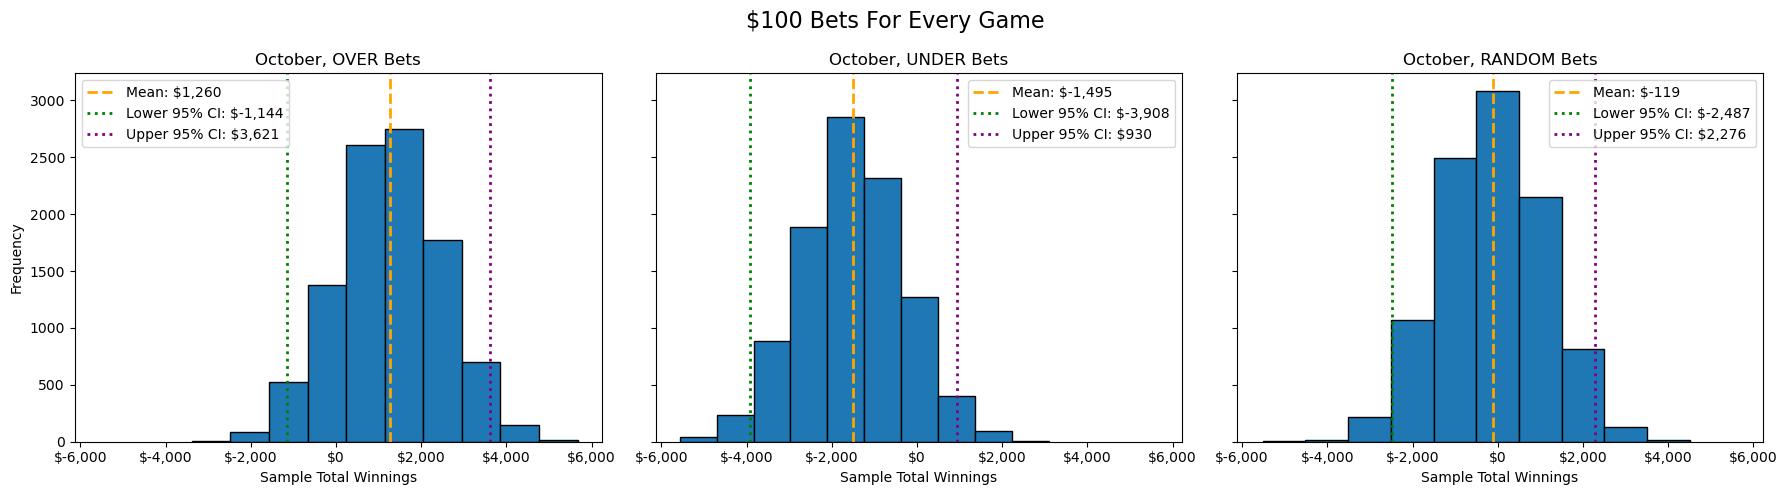

In [330]:
plot_results(october_results, "October")

### November Simulation

In [331]:
november_results_over = run_sampling_simulation(11, WAGER_AMOUNT, BETS_PER_MONTH, 'OVER')
november_results_under = run_sampling_simulation(11, WAGER_AMOUNT, BETS_PER_MONTH, 'UNDER')
november_results_random = run_sampling_simulation(11, WAGER_AMOUNT, BETS_PER_MONTH, 'RANDOM')

november_results = [
        ("OVER", november_results_over),
        ("UNDER", november_results_under),
        ("RANDOM", november_results_random)
    ]

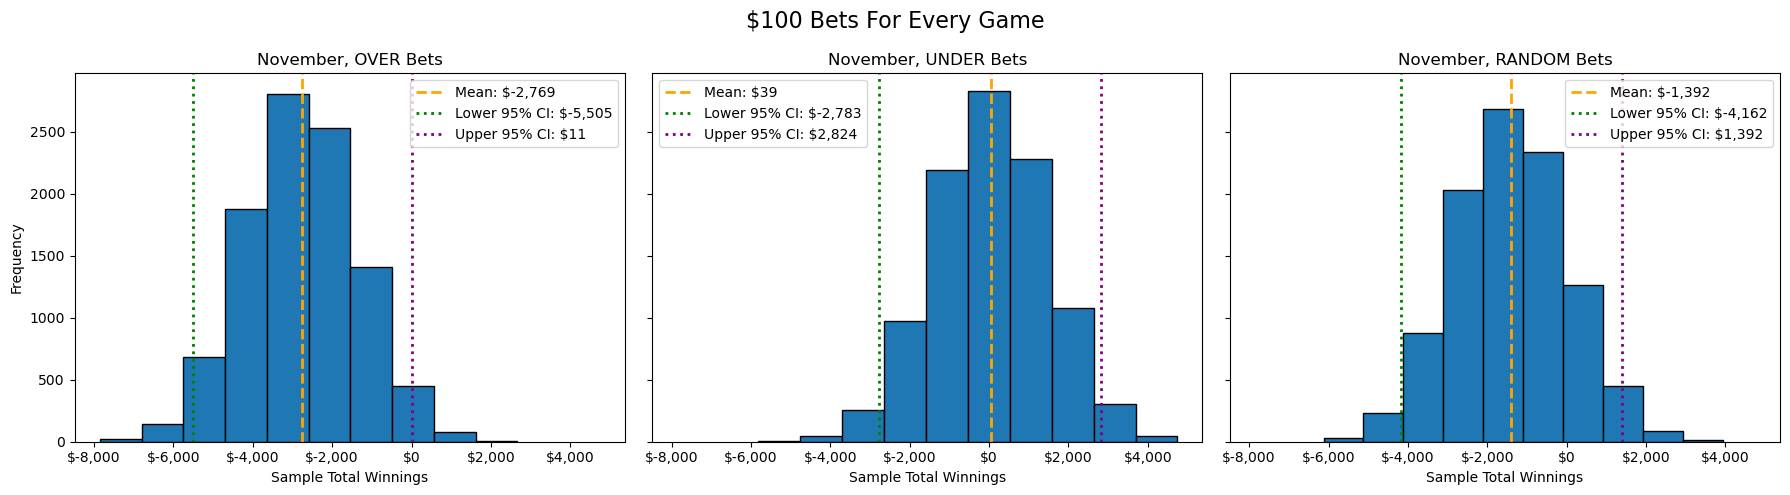

In [332]:
plot_results(november_results, "November")

### April Simulation

In [333]:
april_results_over = run_sampling_simulation(4, WAGER_AMOUNT, BETS_PER_MONTH, 'OVER')
april_results_under = run_sampling_simulation(4, WAGER_AMOUNT, BETS_PER_MONTH, 'UNDER')
april_results_random = run_sampling_simulation(4, WAGER_AMOUNT, BETS_PER_MONTH, 'RANDOM')

april_results = [
        ("OVER", april_results_over),
        ("UNDER", april_results_under),
        ("RANDOM", april_results_random)
    ]

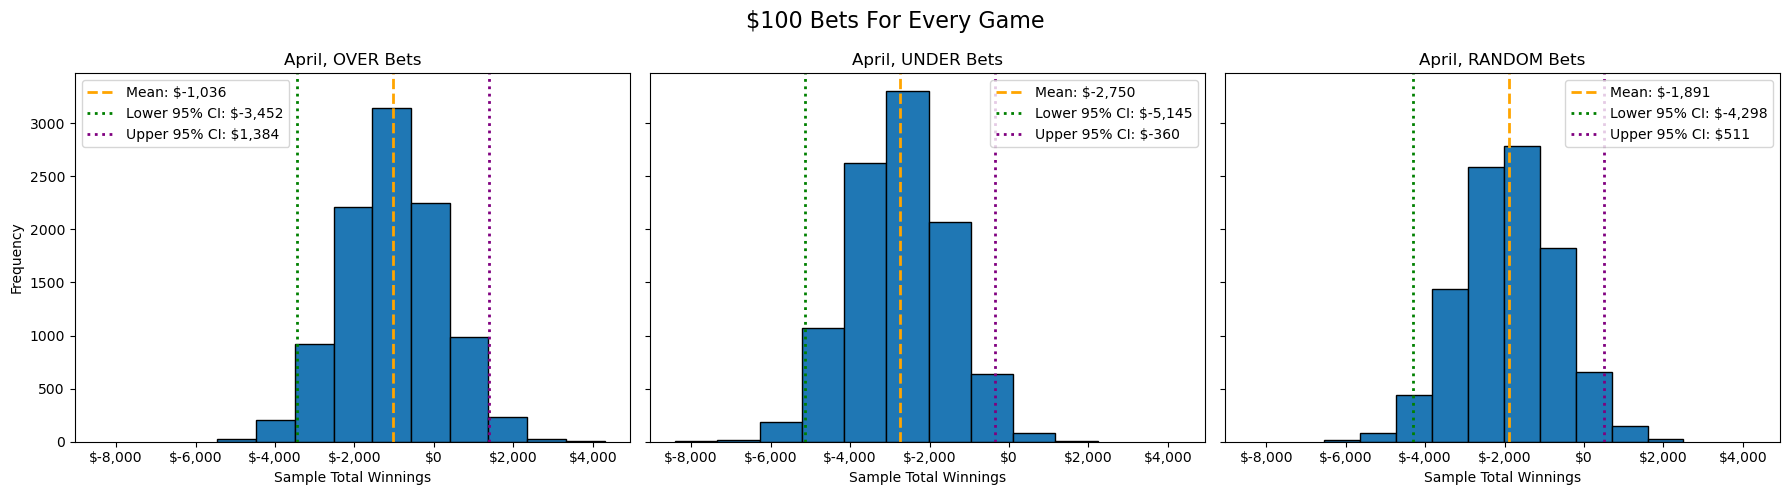

In [334]:
plot_results(april_results, "April")

### Combine results in one plot

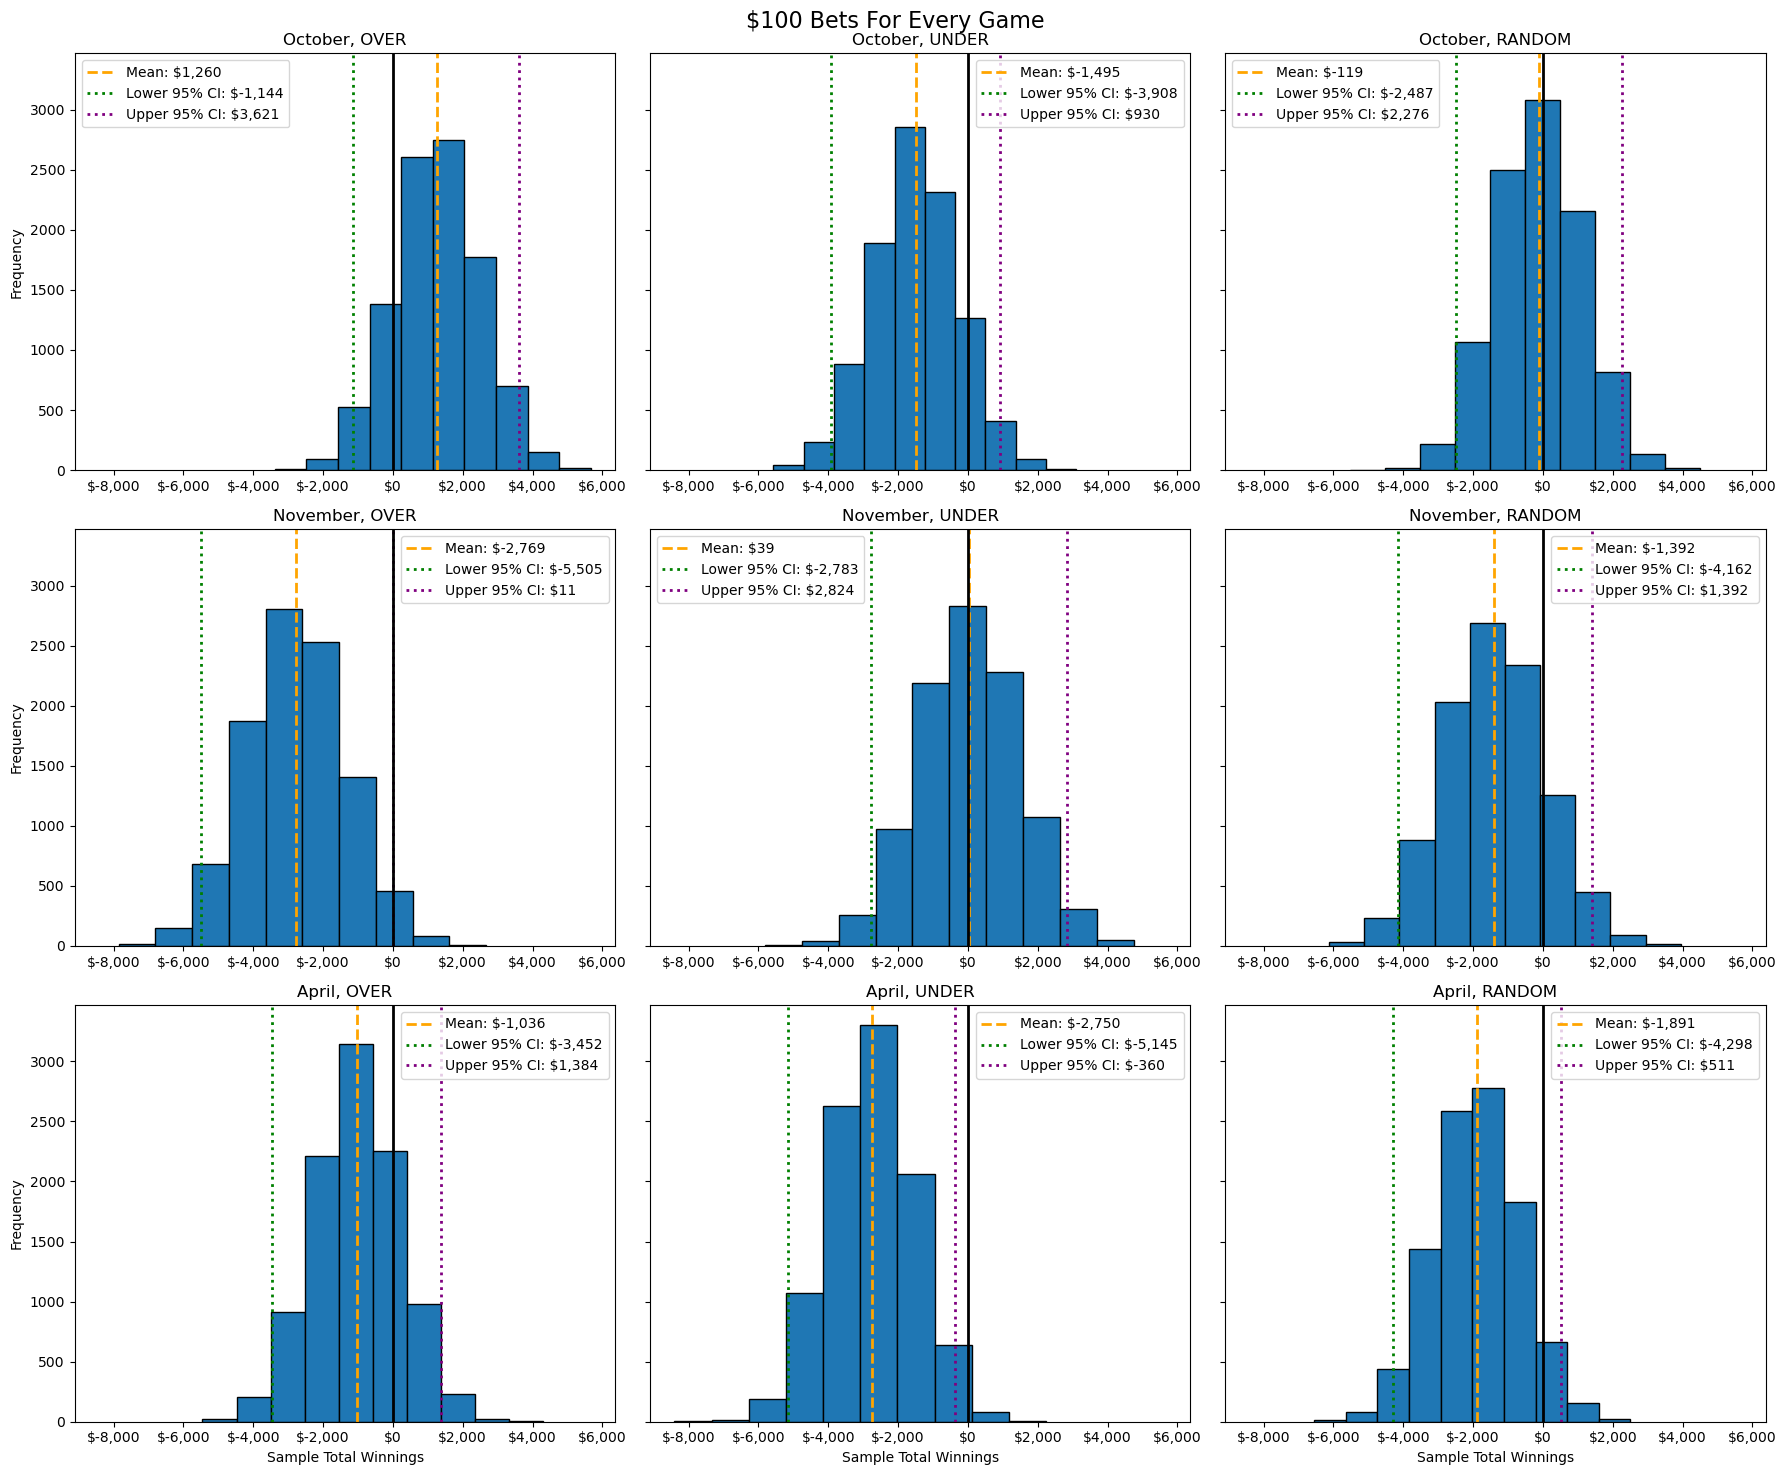

In [335]:
fig, axes = plt.subplots(3, 3, figsize=(18, 15), sharey=True, sharex=True)
if FULL_MONTH:
    fig.suptitle(f"{dollar_formatter(WAGER_AMOUNT, None)} Bets For Every Game", fontsize=16)
else:
    fig.suptitle(f"For {BETS_PER_MONTH} {dollar_formatter(WAGER_AMOUNT, None)} Bets Per Month", fontsize=16)
    
months = [
    ("October", [october_results_over, october_results_under, october_results_random]),
    ("November", [november_results_over, november_results_under, november_results_random]),
    ("April", [april_results_over, april_results_under, april_results_random])
]
bet_labels = ["OVER", "UNDER", "RANDOM"]

for row_idx, (month_label, month_results) in enumerate(months):
    for col_idx, (bet_label, result) in enumerate(zip(bet_labels, month_results)):
        ax = axes[row_idx, col_idx]
        wager_results = result["wager_results"]
        sample_mean = result["mean"]
        lower = result["lower"]
        upper = result["upper"]
        ax.hist(wager_results, edgecolor='black')
        ax.set_title(f"{month_label}, {bet_label}")
        ax.axvline(sample_mean, color='orange', linestyle='dashed', linewidth=2, label=f'Mean: {dollar_formatter(sample_mean, None)}')
        ax.axvline(lower, color='green', linestyle='dotted', linewidth=2, label=f'Lower 95% CI: {dollar_formatter(lower, None)}')
        ax.axvline(upper, color='purple', linestyle='dotted', linewidth=2, label=f'Upper 95% CI: {dollar_formatter(upper, None)}')
        ax.tick_params(axis='x', labelbottom=True)
        ax.xaxis.set_major_formatter(FuncFormatter(dollar_formatter))
        ax.axvline(0, color='black', linestyle='-', linewidth=2, zorder=3)
        ax.legend()
        if col_idx == 0:
            ax.set_ylabel('Frequency')
        if row_idx == 2:
            ax.set_xlabel('Sample Total Winnings')

plt.tight_layout()
plt.show()

### A better visualization

This plot is saved to results/ directory

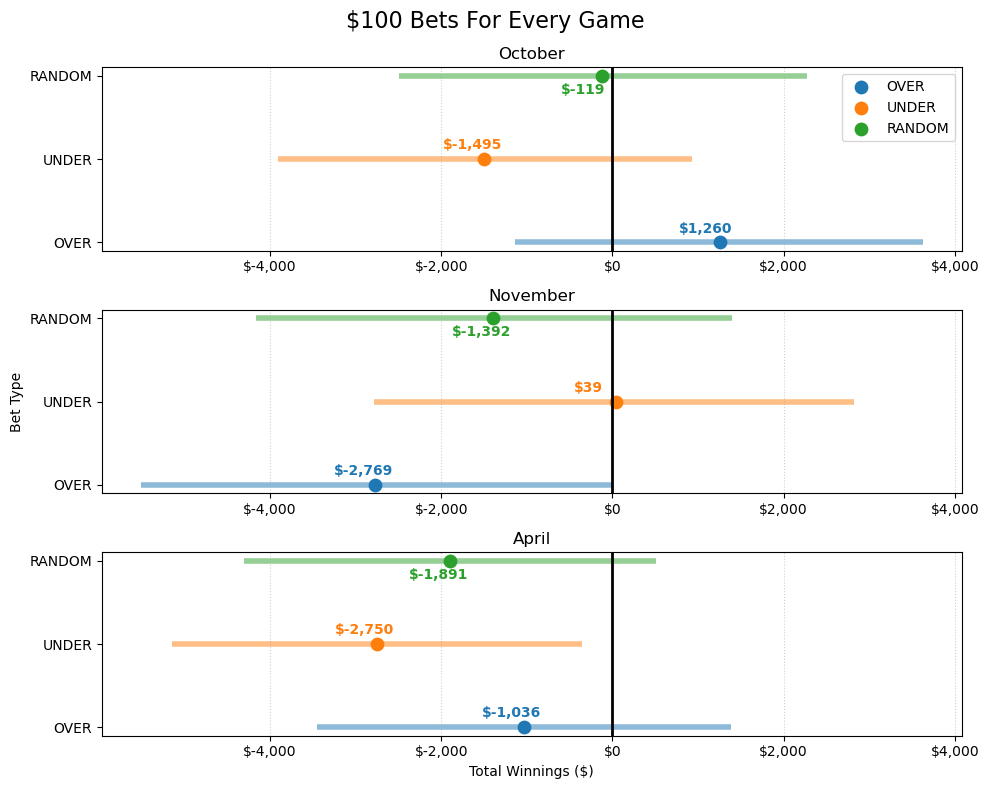

In [336]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
if FULL_MONTH:
    fig.suptitle(f"{dollar_formatter(WAGER_AMOUNT, None)} Bets For Every Game", fontsize=16)
else:
    fig.suptitle(f"For {BETS_PER_MONTH} {dollar_formatter(WAGER_AMOUNT, None)} Bets Per Month", fontsize=16)

months = [
    ("October", october_results),
    ("November", november_results),
    ("April", april_results)
]
bet_labels = ["OVER", "UNDER", "RANDOM"]
colors = ["tab:blue", "tab:orange", "tab:green"]

for row_idx, (month_label, results) in enumerate(months):
    ax = axes[row_idx]
    means = [result[1]["mean"] for result in results]
    lowers = [result[1]["lower"] for result in results]
    uppers = [result[1]["upper"] for result in results]
    # Plot CI lines
    for i in range(3):
        ax.hlines(y=i, xmin=lowers[i], xmax=uppers[i], color=colors[i], lw=4, alpha=0.5, zorder=1)
        ax.scatter(means[i], i, color=colors[i], s=80, label=bet_labels[i], zorder=2)
        xytext = (-30, -10) if (i == 2) else (-30, 10)
        ax.annotate(
            dollar_formatter(means[i], None),
            (means[i], i),
            xytext=xytext,
            textcoords='offset points',
            va='center',
            ha='left',
            fontsize=10,
            color=colors[i],
            fontweight='bold'
        )
    ax.set_yticks([0, 1, 2])
    ax.set_yticklabels(bet_labels)
    ax.set_title(f"{month_label}")
    ax.grid(axis='x', linestyle=':', alpha=0.6, zorder=0)
    ax.axvline(0, color='black', linestyle='-', linewidth=2, zorder=3)
    ax.tick_params(axis='x', labelbottom=True)
    ax.xaxis.set_major_formatter(FuncFormatter(dollar_formatter))
    if row_idx == 2:
        ax.set_xlabel(f"Total Winnings ($)")
    if row_idx == 1:
        ax.set_ylabel("Bet Type")
    # Only show legend on first row
    if row_idx == 0:
        ax.legend(loc="best")

plt.tight_layout()
plt.show()


os.makedirs("results", exist_ok=True)

if FULL_MONTH:
    fig.savefig(f"results/{WAGER_AMOUNT}_Dollar_Bets_Full_Month_Confidence_Interval.png", dpi=300)
else:
    fig.savefig(f"results/{WAGER_AMOUNT}_Dollar_Bets_{BETS_PER_MONTH}_Games_Per_Month_Confidence_Interval.png", dpi=300)


### Calculate the ROI

ROI = (Total money won for month / Total money wager for month) * 100

In [337]:
total_wager_amount_per_month = WAGER_AMOUNT * BETS_PER_MONTH

months_labels = ["October", "November", "April"]
results_by_month = [october_results, november_results, april_results]
bet_labels = ["OVER", "UNDER", "RANDOM"]

roi_data = []
for month_label, results in zip(months_labels, results_by_month):
    for bet_label, result in results:
        if FULL_MONTH:
            if month_label == "October":
                month_data = over_under_df[over_under_df['MONTH'] == 10]
                total_wager_amount_per_month = WAGER_AMOUNT * month_data.shape[0]
            elif month_label == "November":
                month_data = over_under_df[over_under_df['MONTH'] == 11]
                total_wager_amount_per_month = WAGER_AMOUNT * month_data.shape[0]
            else:
                month_data = over_under_df[over_under_df['MONTH'] == 4]
                total_wager_amount_per_month = WAGER_AMOUNT * month_data.shape[0]
        mean = result["mean"]
        roi = mean / total_wager_amount_per_month * 100
        roi_data.append({
            "Month": month_label,
            "Bet Type": bet_label,
            "Mean Winnings": dollar_formatter(mean, None),
            "ROI (%)": f"{roi:.2f}%"
        })

roi_df = pd.DataFrame(roi_data)
roi_table = roi_df.pivot(index="Month", columns="Bet Type", values="ROI (%)")
display(roi_table)

Bet Type,OVER,RANDOM,UNDER
Month,,,
April,-6.02%,-11.00%,-15.99%
November,-12.59%,-6.33%,0.18%
October,7.59%,-0.72%,-9.01%


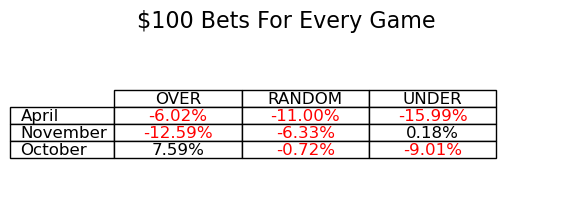

In [338]:
fig, ax = plt.subplots(figsize=(6, 2))  # Adjust size as needed
if FULL_MONTH:
    fig.suptitle(f"{dollar_formatter(WAGER_AMOUNT, None)} Bets For Every Game", fontsize=16)
else:
    fig.suptitle(f"For {BETS_PER_MONTH} {dollar_formatter(WAGER_AMOUNT, None)} Bets Per Month", fontsize=16)

ax.axis('off')  # Hide axes

# Draw table
tbl = table(ax, roi_table, loc='center', cellLoc='center', colWidths=[0.2]*len(roi_table.columns))
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1.2, 1.2)

# Color negative ROI values red, but skip row==0 (header) and col==(-1, 0) (row labels)
for (row, col), cell in tbl.get_celld().items():
    if row == 0 or col == -1:
        continue  # skip header and month labels
    val = roi_table.iloc[row-1, col]  # row-1 because table header is row 0
    try:
        roi_val = float(str(val).replace('%', ''))
        if roi_val < 0:
            cell.get_text().set_color('red')
    except Exception:
        pass


plt.tight_layout()
os.makedirs("results", exist_ok=True)

if FULL_MONTH:
    plt.savefig(f"results/{WAGER_AMOUNT}_Dollar_Bets_Every_Game_ROI_Table.png", dpi=300)
else:
    plt.savefig(f"results/{WAGER_AMOUNT}_Dollar_Bets_{BETS_PER_MONTH}_Games_Per_Month_ROI_Table.png", dpi=300)
plt.show()

## Bootstrapping Confidence Interval Conclusion

This turned out to be a super interesting exercise. After the [Monthly Scoring Analysis](./monthly-scoring-analysis.ipynb) I assumed that the betting the Over in October advice was rubbish. However, it would appear that it is a legitimate trend (at least last season it was). A %7.5 return on investment is solid. However, it's gambiling and losses are still within our confidence intervals so I would not go dumping my life savings on this one. 

I would say these results say more about the ability of sports books to set lines later in the season than the start of the season. I think, paired with the scoring analysis results, it shows that scoring trends don't have much to do with Over/Unders hitting. I think the uncertainty that the beggining of the season brings, makes the line setting more difficult.